In [1]:
import tensorflow as tf
tf.__version__

'1.13.1'

In [2]:
tf.test.is_gpu_available()

False

In [3]:
import pandas as pd
import numpy as np

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
#tf.random.set_seed(seed)

In [4]:
dataset = pd.read_csv('dataset/train.csv')
#dataset['sentiment'] = [1 if record == 'positive' else 0 for record in dataset['sentiment']]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3235 entries, 0 to 3234
Data columns (total 6 columns):
id                 3235 non-null float64
original_text      3235 non-null object
lang               3231 non-null object
retweet_count      3231 non-null object
original_author    3235 non-null object
sentiment_class    3235 non-null int64
dtypes: float64(1), int64(1), object(4)
memory usage: 151.7+ KB


In [5]:
dataset.drop(['id','lang','retweet_count','original_author'],axis=1,inplace=True)
dataset.head()

,original_text,sentiment_class
0,Happy #MothersDay to all you amazing mothers o...,0
1,Happy Mothers Day Mum - I'm sorry I can't be t...,0
2,Happy mothers day To all This doing a mothers ...,-1
3,Happy mothers day to this beautiful woman...ro...,0
4,Remembering the 3 most amazing ladies who made...,-1


In [6]:
tweet = dataset['original_text'].values
sentiments = dataset['sentiment_class'].values

train_reviews = tweet[:500]
val_reviews = tweet[500:1000]
test_reviews = tweet[1000:]



train_sentiments = sentiments[:500]
val_sentiments = sentiments [500:1000]
test_sentiments = sentiments[1000:]

train_reviews.shape, val_reviews.shape, test_reviews.shape

((500,), (500,), (2235,))

In [7]:
!pip3 install contractions
!pip3 install textsearch
!pip3 install tqdm
!pip3 install nltk
!pip3 install beautifulsoup4
import nltk
nltk.download('punkt')

You should consider upgrading via the 'c:\users\dell\miniconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\dell\miniconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\dell\miniconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\dell\miniconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\dell\miniconda3\python.exe -m pip install --upgrade pip' command.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def pre_process_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        doc = strip_html_tags(doc)
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))
        doc = doc.lower()
        doc = remove_accented_chars(doc)
        doc = contractions.fix(doc)
        # lower case and remove special characters\whitespaces
        doc = re.sub(r'[^a-zA-Z0-9\s]', ' ', doc, re.I|re.A)
        doc = re.sub(' +', ' ', doc)
        doc = doc.strip()  
        norm_docs.append(doc)
    return norm_docs

In [9]:
%%time

norm_train_texts = pre_process_corpus(train_reviews)
norm_val_texts = pre_process_corpus(val_reviews)
norm_test_texts = pre_process_corpus(test_reviews)

100%|████████████████████████████████████████████████████████████████████████████| 2235/2235 [00:00<00:00, 3590.82it/s]


Wall time: 1.2 s


In [10]:
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_texts)
t.word_index['<PAD>'] = 0

In [11]:
print(max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
      min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
      t.word_index['<UNK>'])

('vlsouxmsuq', 3700) ('<PAD>', 0) 1


In [12]:
train_sequences = t.texts_to_sequences(norm_train_texts)
val_sequences = t.texts_to_sequences(norm_val_texts)
test_sequences = t.texts_to_sequences(norm_test_texts)

In [13]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=3701
Number of Documents=500


(0, 100)

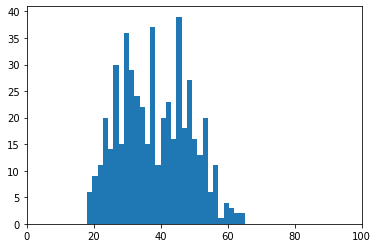

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist([len(doc.split()) for doc in norm_train_texts], bins=30);
plt.xlim([0, 100])

In [17]:
MAX_SEQUENCE_LENGTH = 500

# pad dataset to a maximum review length in words
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_val = tf.keras.preprocessing.sequence.pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((500, 500), (2235, 500))

In [18]:
VOCAB_SIZE = len(t.word_index)
EMBED_SIZE = 300
EPOCHS=100
BATCH_SIZE=128

In [19]:
word2idx = t.word_index
FASTTEXT_INIT_EMBEDDINGS_FILE = 'wiki-news-300d-1M-subword.vec'


def load_pretrained_embeddings(word_to_index, max_features, embedding_size, embedding_file_path):    
    
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*row.split(" ")) 
                                for row in open(embedding_file_path, encoding="utf8", errors='ignore') 
                                    if len(row)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_to_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))
    
    for word, idx in word_to_index.items():
        if idx >= max_features: 
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [20]:
ft_embeddings = load_pretrained_embeddings(word_to_index=word2idx, 
                                           max_features=VOCAB_SIZE, 
                                           embedding_size=EMBED_SIZE, 
                                           embedding_file_path=FASTTEXT_INIT_EMBEDDINGS_FILE)
ft_embeddings.shape

C:\Users\DELL\Miniconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


(3701, 300)

In [21]:
# create the model
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    weights=[ft_embeddings],
                                    trainable=True,
                                    input_length=MAX_SEQUENCE_LENGTH))

model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=5, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=5))

model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=5))

model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=5))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


TypeError: Input 'y' of 'Equal' Op has type float32 that does not match type int32 of argument 'x'.

In [24]:
# Fit the model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=3,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(X_train, train_sentiments, 
          validation_data=(X_val, val_sentiments),
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          shuffle=True,
          callbacks=[es],
          verbose=1)

Train on 5000 samples, validate on 5000 samples
Epoch 1/100
5000/5000 [==============================] - 12s 2ms/sample - loss: 0.6946 - accuracy: 0.4942 - val_loss: 0.6920 - val_accuracy: 0.5564
Epoch 2/100
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.6516 - accuracy: 0.6012 - val_loss: 0.4277 - val_accuracy: 0.8154
Epoch 3/100
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.2726 - accuracy: 0.8904 - val_loss: 0.3079 - val_accuracy: 0.8708
Epoch 4/100
5000/5000 [==============================] - 10s 2ms/sample - loss: 0.0636 - accuracy: 0.9808 - val_loss: 0.4348 - val_accuracy: 0.8630
Epoch 5/100
5000/5000 [==============================] - 10s 2ms/sample - loss: 0.0082 - accuracy: 0.9976 - val_loss: 0.6429 - val_accuracy: 0.8636
Epoch 6/100
5000/5000 [==============================] - 10s 2ms/sample - loss: 6.0471e-04 - accuracy: 0.9998 - val_loss: 0.8038 - val_accuracy: 0.8738
Epoch 00006: early stopping


In [25]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

predictions = model.predict_classes(X_test, batch_size=2048, verbose=0).ravel()

print("Accuracy: %.2f%%" % (accuracy_score(test_sentiments, predictions)*100))
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions))

Accuracy: 86.40%
             precision    recall  f1-score   support

          0       0.83      0.91      0.87     20028
          1       0.90      0.81      0.86     19972

avg / total       0.87      0.86      0.86     40000



,0,1
0,18293,1735
1,3705,16267
